# Tutorial of GSVA using data GSE10245

#### Contributor: Antonio Mora, Chengshu Xie 
#### Date of first version: 2018-11-20
#### Date of last review: 2020-05-26 
#### Summary:

This is the tutorial about using how to use R package `GSVA`. We use the example data, [part of GSE10245](https://github.com/mora-lab/benchmarks/blob/master/single-sample/workflows/data/GSE10245.RDS), for this tutorial, which is available in Github. The dataset is [a microarray dataset about non-small cell lung cancer(NSCLC) in GEO database](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE10245).
 . 

#### Contents:
* [1. Data Preparation](#link1)    <br>
    * [1.1 Prerequisites](#link2)     <br>
    * [1.2 Import data](#link3)   <br>
* [2. Method application](#link4)  <br>
    * [2.1 Calculate pathway scores using `gsva()` with PLAGE method](#link5)     <br>
    * [2.2 Calculate pathway scores using `gsva()` with ZSCORE method](#link6)   <br>
    * [2.3 Calculate pathway scores using `gsva()` with SSGSEA method](#link7)     <br>
    * [2.4 Calculate pathway scores using `gsva()` with GSVA method](#link8)   <br>
* [3. Heatmap](#link9)
        
    
## <a id=link1>1. Data Preparation</a>

### <a id=link2>1.1 Prerequisites</a>

R package, `GSVA`, needs to be installed and loaded in the R session, this can be done easily with the following chunk of code: 

In [1]:
install.packages("BiocManager")
BiocManager::install("GSVA")
BiocManager::install("GSEABase")
BiocManager::install("pheatmap")


suppressPackageStartupMessages(library(GSVA))
suppressPackageStartupMessages(library(GSEABase))
suppressPackageStartupMessages(library(pheatmap))

### <a id=link3>1.2 Import data</a>

The main functions in `GSVA`, require the expression data, phenotype data and the reference pathways(gene sets). <br>
All the data could be obtained from [GitHub](https://github.com/mora-lab/benchmarks/blob/master/single-sample/workflows/data). About the reference pathway, you could download the `.GMT` file from [GSEA|MSigDB](http://software.broadinstitute.org/gsea/msigdb/download_file.jsp?filePath=/resources/msigdb/7.0/c2.cp.kegg.v7.0.symbols.gmt), which contains KEGG pathway information and could be read into R via `getGmt()` in `GSEABase` package. What users need to do is to download them before loading the example data into R session. <br>
Then use the following R codes to load them: 

In [2]:
### read data into R
### Not run, to run it, download the example .RDS file and change the address in "readRDS()"
GSE10245 = readRDS("git@github.com:mora-lab/benchmarks/tree/master/single-sample/workflows/data/GSE10245.RDS")
KEGG_genesetcollection = GSEABase::getGmt("git@github.com:mora-lab/benchmarks/tree/master/single-sample/data/example_pathway.gmt", 
                                          geneIdType = SymbolIdentifier())   ### will produce warning but ignore it

Warning message in GSEABase::getGmt("E:\\University\\GMU\\benchmarks\\single-sample\\workflows\\data\\example_pathway.gmt", :
"7 record(s) contain duplicate ids: KEGG_calcium_signaling_pathway, KEGG_cell_cycle, ..., KEGG_P53_signaling_pathway, KEGG_RAS_signaling_pathway"


To see the contents of the `GSE10245` object and `KEGG_genesetcollection` onject, use the commands: 

In [3]:
head(GSE10245)

,GSM258551,GSM258552,GSM258553,GSM258554,GSM258555,GSM258556,GSM258557,GSM258558,GSM258559,GSM258560,...,GSM258599,GSM258600,GSM258601,GSM258602,GSM258603,GSM258604,GSM258605,GSM258606,GSM258607,GSM258608
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
normal,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000,...,0.00000,1.00000,1.00000,1.00000,0.00000,1.00000,1.00000,1.00000,1.00000,1.00000
COX1,15.31219,15.33513,15.14794,15.23526,15.40252,15.23544,15.26664,15.23615,15.53066,15.32330,...,15.35491,15.49565,15.39272,15.48079,15.37211,15.47678,15.12510,14.82045,15.40969,15.14544
EEF1A1,15.18050,15.18023,15.26209,15.24665,15.27287,15.18183,15.16270,15.12682,15.31581,15.40652,...,15.16511,15.18418,15.13071,15.19139,15.17459,15.19240,15.16712,15.29834,15.11026,15.08846
IGK,15.39448,15.37585,15.25943,15.25016,11.99687,15.05328,15.45070,15.39105,14.65891,14.70683,...,15.17709,15.37075,14.98571,14.77190,15.04847,15.23630,14.67816,15.12034,15.34982,15.37227
TMSB4X,15.16448,15.33779,14.88632,14.72336,14.73436,14.75568,15.09072,14.74747,15.35730,14.56345,...,14.86133,15.18403,14.71638,14.88559,14.95012,14.88124,15.23630,14.60038,15.15858,15.05968
ATP6,14.76594,14.93945,14.53067,14.95695,14.96051,14.76712,14.64807,14.84704,14.89766,15.09347,...,14.96365,15.08632,14.99458,15.07931,14.95273,15.04735,14.12465,14.31763,14.95427,14.73761


In [4]:
str(KEGG_genesetcollection)

Formal class 'GeneSetCollection' [package "GSEABase"] with 1 slot
  ..@ .Data:List of 8
  .. ..$ :Formal class 'GeneSet' [package "GSEABase"] with 13 slots
  .. .. .. ..@ geneIdType      :Formal class 'SymbolIdentifier' [package "GSEABase"] with 2 slots
  .. .. .. .. .. ..@ type      : chr "Symbol"
  .. .. .. .. .. ..@ annotation: chr ""
  .. .. .. ..@ geneIds         : chr [1:296] "CACNA1A" "CACNA1B" "CACNA1C" "CACNA1D" ...
  .. .. .. ..@ setName         : chr "KEGG_MAPK_signaling_pathway"
  .. .. .. ..@ setIdentifier   : chr "LAPTOP-LB63B2Q8:15964:Wed May 27 03:06:17 2020:2"
  .. .. .. ..@ shortDescription: chr "https://www.kegg.jp/kegg-bin/show_pathway? hsa04010 "
  .. .. .. ..@ longDescription : chr ""
  .. .. .. ..@ organism        : chr ""
  .. .. .. ..@ pubMedIds       : chr(0) 
  .. .. .. ..@ urls            : chr(0) 
  .. .. .. ..@ contributor     : chr(0) 
  .. .. .. ..@ version         :Formal class 'Versions' [package "Biobase"] with 1 slot
  .. .. .. .. .. ..@ .Data:List o

## <a id=link4>2. Method application</a>

### <a id=link5>2.1 Calculate pathway scores using  `gsva()` with PLAGE method</a>

Calculate pathway score matrix among all data.

INPUT: matrix, where columns are samples and rows are pathway genes, genesetcollection class, which contains a collection of pathways;<br>
OUTPUT: pathway score matrix.<br>

In [5]:
PLAGE_GSE10245 = gsva(as.matrix(GSE10245[-1,]), KEGG_genesetcollection, mx.diff=FALSE, 
                      verbose=FALSE, parallel.sz=2, method = "plage")
PLAGE_GSE10245

,GSM258551,GSM258552,GSM258553,GSM258554,GSM258555,GSM258556,GSM258557,GSM258558,GSM258559,GSM258560,...,GSM258599,GSM258600,GSM258601,GSM258602,GSM258603,GSM258604,GSM258605,GSM258606,GSM258607,GSM258608
KEGG_MAPK_signaling_pathway,-0.29108029,-0.02295928,0.09000246,-0.20139890,0.2554633,0.06120328,-0.048846870,-0.1907746,-0.119528409,-0.014064501,...,0.08608186,0.001326542,0.10030812,-0.041949007,0.0176929514,0.11324710,0.05597912,-0.084229508,0.020799351,-0.14402303
KEGG_Erbb_signaling_pathway,0.11609698,0.04553556,-0.19748416,0.13263706,-0.2343333,0.11822704,-0.007917451,0.1726151,-0.078597017,0.119756772,...,-0.12196276,0.143147041,-0.05157934,-0.042766649,-0.0907698178,0.04834090,-0.08324285,0.029221313,-0.114327908,0.03445154
KEGG_cell_cycle,-0.13283720,-0.07096367,0.17742405,-0.18748911,0.2348369,0.10090093,-0.041176547,-0.2785895,-0.016077985,0.036140426,...,0.19594824,-0.019289601,0.07194450,-0.040370817,0.0225218434,0.02751683,0.12466290,-0.036252882,0.056695764,-0.15014964
KEGG_P53_signaling_pathway,0.13268795,0.06001787,-0.18057065,0.17621959,-0.2038719,-0.02806190,-0.027313432,0.2442686,0.039974148,-0.034831630,...,-0.19369406,0.046968686,-0.02769730,0.060999870,-0.0145066676,-0.08802716,-0.11989843,0.056402539,-0.021592152,0.11428935
KEGG_PI3K-AKT_signaling_pathway,-0.43471493,0.05628163,-0.12056387,-0.27032161,0.2251704,0.07218739,-0.090731652,-0.2109247,-0.151956032,-0.008063917,...,-0.04240696,0.044859179,0.17356521,0.006112167,-0.1331614374,0.19733469,-0.02602965,-0.022289095,0.008129578,-0.09972839
KEGG_RAS_signaling_pathway,0.23642777,0.14076102,-0.01347574,0.16626505,-0.2509666,-0.19405654,0.164870317,0.2125830,0.133671788,0.002849367,...,-0.01399151,0.033754922,-0.16475464,0.007553428,-0.0007996159,-0.13509142,-0.08668778,0.031368533,-0.107756275,0.19447651
KEGG_calcium_signaling_pathway,0.48130913,-0.08018514,0.18473565,0.26365225,-0.1773240,-0.07048114,0.087549102,0.1973610,0.098662375,-0.027167818,...,0.04234906,-0.049498349,-0.16847805,-0.020830346,0.1582782342,-0.13873473,0.08160477,-0.001730143,0.007072124,0.10614625
KEGG_NON_small_cell_lung_cancer,-0.08447247,-0.19302830,0.08709470,-0.08520266,0.2236117,0.15313701,-0.159644827,-0.1912377,-0.006669455,-0.037561349,...,0.05561406,-0.190520851,0.12894328,0.029702901,-0.0040451067,0.09510938,0.23953397,0.011702646,0.023623338,-0.12003386


### <a id=link6>2.2 Calculate pathway scores using  `gsva()` with ZSCORE method</a>

Calculate pathway score matrix among all data.

INPUT: matrix, where columns are samples and rows are pathway genes, genesetcollection class, which contains a collection of pathways;<br>
OUTPUT: pathway score matrix.<br>


In [6]:
ZSCORE_GSE10245 = gsva(as.matrix(GSE10245[-1,]), KEGG_genesetcollection, mx.diff=FALSE, 
                       verbose=FALSE, parallel.sz=2, method = "zscore")
ZSCORE_GSE10245

,GSM258551,GSM258552,GSM258553,GSM258554,GSM258555,GSM258556,GSM258557,GSM258558,GSM258559,GSM258560,...,GSM258599,GSM258600,GSM258601,GSM258602,GSM258603,GSM258604,GSM258605,GSM258606,GSM258607,GSM258608
KEGG_MAPK_signaling_pathway,6.8266750,1.93470071,-2.7584988,1.922586,-2.0392007,-2.9147453,1.3505273,2.1467858,5.6185783,-0.83067545,...,-0.8188303,-0.31117261,-2.64219090,1.5115184,0.2545326,-0.9516518,-0.3113611,-1.3175959,-0.9223919,4.3083512
KEGG_Erbb_signaling_pathway,0.6928479,-0.01649403,-2.3611755,-1.187488,0.2314670,-2.1607878,-0.8654612,0.5296621,2.9466654,-1.36948508,...,0.2157653,1.24875569,0.39946181,2.3394321,-0.4345001,-2.5746945,-1.1757594,-0.6095950,1.2200569,0.9881495
KEGG_cell_cycle,-3.2622103,-2.90951446,5.9935060,-4.739992,7.9513129,2.5546863,-1.4560576,-7.4758309,-0.1450488,0.00566686,...,5.9611343,-0.57013482,0.87782221,-1.3079453,2.3496382,1.6944832,3.0120974,-1.1239421,0.3578821,-3.3942310
KEGG_P53_signaling_pathway,-0.5890056,-0.11435009,0.3708695,-1.576814,2.4902975,-0.1908539,0.4190720,-2.1286480,1.0676089,-1.08731937,...,3.0973961,-1.91605774,-1.30743505,0.6503573,1.1962686,-0.3734475,-0.7422923,2.3797911,-1.4650454,-0.8571637
KEGG_PI3K-AKT_signaling_pathway,9.9754008,-0.67721354,-0.5592913,2.699123,-4.2654106,-5.1422682,2.5825032,1.9874696,7.2673743,0.11806976,...,1.0569405,0.02160106,-3.36267587,1.9919039,3.0701704,-1.4243965,0.1330790,-2.2721382,-1.2041098,4.7943122
KEGG_RAS_signaling_pathway,5.8580823,0.85671431,-1.1996108,1.396492,-3.5986435,-4.4168204,1.4030584,3.1289489,5.1264198,0.01926179,...,-0.9112256,1.50265754,-2.55952700,1.4584792,0.7637722,-0.3982410,-1.6558409,-2.1944113,-2.4304638,4.1857502
KEGG_calcium_signaling_pathway,12.7577448,-0.95870246,4.4218723,6.336522,-4.2968255,-1.7425705,2.2255870,5.1302031,4.5620851,1.10868023,...,0.9944339,-1.85173992,-4.78807751,-0.2735057,3.0806964,-4.2891983,-0.1401668,-0.9792805,0.4982211,4.5170955
KEGG_NON_small_cell_lung_cancer,0.6968979,0.41093901,-1.2015522,-1.195463,-0.2819326,-1.4263019,0.5496865,0.4498521,2.1605862,-1.04130308,...,0.6926600,1.83384320,0.01817867,0.7568846,-0.1090915,-2.5863251,-2.0539135,-0.6775473,0.5804543,2.2073435


### <a id=link7>2.3 Calculate pathway scores using  `gsva()` with SSGSEA method</a>

Calculate pathway score matrix among all data.

INPUT: matrix, where columns are samples and rows are pathway genes, genesetcollection class, which contains a collection of pathways;<br>
OUTPUT: pathway score matrix.<br>


In [7]:
SSGSEA_GSE10245 = gsva(as.matrix(GSE10245[-1,]), KEGG_genesetcollection, mx.diff=FALSE, 
                       verbose=FALSE, parallel.sz=2, method = "ssgsea")
SSGSEA_GSE10245

,GSM258551,GSM258552,GSM258553,GSM258554,GSM258555,GSM258556,GSM258557,GSM258558,GSM258559,GSM258560,...,GSM258599,GSM258600,GSM258601,GSM258602,GSM258603,GSM258604,GSM258605,GSM258606,GSM258607,GSM258608
KEGG_MAPK_signaling_pathway,0.5078001,0.47996762,0.40116233,0.44850486,0.45546212,0.42917852,0.47845709,0.45815401,0.50142528,0.45329872,...,0.43732376,0.45607341,0.44527759,0.47644222,0.43967542,0.46537507,0.455063454,0.44448472,0.44514726,0.5006785
KEGG_Erbb_signaling_pathway,0.6452433,0.62110461,0.57758944,0.58952567,0.62956532,0.57941707,0.61426283,0.62938388,0.69284441,0.60691128,...,0.61465467,0.63089208,0.62313571,0.68730569,0.61523983,0.55820616,0.621731318,0.62464347,0.63306300,0.6394703
KEGG_cell_cycle,0.7503654,0.77730542,0.91774266,0.70018286,0.95013183,0.84953835,0.80692887,0.65301823,0.80065529,0.80565112,...,0.91152691,0.80186006,0.82329379,0.77335566,0.85087118,0.82826949,0.877615373,0.79306970,0.82206107,0.7441685
KEGG_P53_signaling_pathway,0.8058494,0.81880643,0.85427291,0.77107581,0.89399680,0.80800559,0.86898143,0.74349995,0.82623249,0.78364727,...,0.88479427,0.75616112,0.73461518,0.81067673,0.85649855,0.82360419,0.824940980,0.86446932,0.78845874,0.7907887
KEGG_PI3K-AKT_signaling_pathway,0.5103691,0.46936191,0.44755677,0.45027239,0.46808893,0.40492385,0.50822134,0.46158888,0.51751856,0.46659136,...,0.46684286,0.47265356,0.44783751,0.48415266,0.48312298,0.47943114,0.464952137,0.43803353,0.44153641,0.5137066
KEGG_RAS_signaling_pathway,0.4385654,0.40609862,0.37238525,0.37281121,0.38622557,0.34646184,0.41870470,0.41207737,0.42854355,0.39676373,...,0.38215527,0.42794382,0.37239773,0.41179640,0.40018996,0.39986370,0.363782423,0.36845053,0.35983999,0.4483006
KEGG_calcium_signaling_pathway,0.1168178,0.05948618,0.07062158,0.05804547,0.05116946,0.06873643,0.08460785,0.09025082,0.09395811,0.09247826,...,0.05368799,0.05622279,0.01517654,0.05635601,0.06428239,0.01466231,0.006080114,0.05194754,0.08162728,0.1022816
KEGG_NON_small_cell_lung_cancer,0.6707256,0.67010395,0.64058596,0.62490041,0.67032753,0.61342910,0.68595804,0.67834961,0.69191094,0.62986824,...,0.65196477,0.70122802,0.62567361,0.66766816,0.66397446,0.60700863,0.622275252,0.64832228,0.63990353,0.6947287


### <a id=link8>2.4 Calculate pathway scores using  `gsva()` with GSVA method</a>

Calculate pathway score matrix among all data.

INPUT: matrix, where columns are samples and rows are pathway genes, genesetcollection class, which contains a collection of pathways;<br>
OUTPUT: pathway score matrix.<br>


In [8]:
GSVA_GSE10245 = gsva(as.matrix(GSE10245[-1,]), KEGG_genesetcollection, mx.diff=FALSE, 
                     verbose=FALSE, parallel.sz=2, method = "gsva")
GSVA_GSE10245

,GSM258551,GSM258552,GSM258553,GSM258554,GSM258555,GSM258556,GSM258557,GSM258558,GSM258559,GSM258560,...,GSM258599,GSM258600,GSM258601,GSM258602,GSM258603,GSM258604,GSM258605,GSM258606,GSM258607,GSM258608
KEGG_MAPK_signaling_pathway,-0.14075608,0.3172984,-0.3510543,-0.3402886,0.1959850,-0.2258035,0.1931172,-0.2371972,0.2373024,-0.1773990,...,-0.2592068,0.1845145,0.1631346,0.1713856,-0.2684417,0.1824084,-0.2664855,-0.2141057,-0.2410431,0.2534270
KEGG_Erbb_signaling_pathway,-0.32056673,0.2887813,-0.4186778,-0.5197434,0.3099331,-0.3297708,-0.2619040,-0.3096007,0.2444971,-0.2738988,...,-0.2268695,0.2724972,0.3024233,0.2428420,-0.3304042,-0.1389568,-0.3345001,-0.2102477,0.2577302,-0.2058867
KEGG_cell_cycle,-0.53786988,-0.2034432,0.2678409,-0.5910879,0.5217607,0.3575950,-0.3251800,-0.5928278,-0.3125604,0.1759296,...,0.4225526,-0.1965990,0.3154156,-0.2951834,-0.1291439,0.3371044,0.2158651,-0.2446182,0.2296853,-0.4658372
KEGG_P53_signaling_pathway,-0.42303294,0.2684222,-0.2837549,-0.4702931,0.4316244,-0.2022676,-0.1868538,-0.4211485,-0.2459878,-0.2487055,...,0.3379037,-0.2933973,0.1838326,-0.2278016,-0.2511068,0.2550754,-0.2924567,0.3499423,-0.2789656,-0.3546333
KEGG_PI3K-AKT_signaling_pathway,-0.10689399,0.2266460,-0.2928337,-0.2895447,0.1449167,-0.2691547,0.2494727,-0.2365160,0.2121879,0.1771871,...,-0.1887136,0.2046148,0.1422116,0.1789320,-0.1744536,0.1824866,-0.2347006,-0.2478072,-0.2580346,0.2449392
KEGG_RAS_signaling_pathway,-0.09831903,0.2940927,-0.3274265,-0.3641377,-0.1268862,-0.2933234,0.2093660,-0.2238836,0.2341516,0.1816282,...,-0.2540852,0.2558442,0.1645584,0.1951545,-0.2413203,0.1805754,-0.2843348,-0.2258124,-0.2975266,0.2757139
KEGG_calcium_signaling_pathway,0.30994593,0.1861595,0.1785466,0.1707490,-0.2015039,-0.1705302,0.2698291,0.2391199,0.2306919,0.2103959,...,-0.1426449,-0.1712235,-0.2312865,-0.1575402,0.1757673,-0.2024992,-0.2093870,0.1232725,0.1351062,0.2898643
KEGG_NON_small_cell_lung_cancer,-0.31197902,0.2799589,-0.3992770,-0.5229946,0.2960430,-0.3015743,0.1541624,-0.3328583,0.2121004,-0.2993906,...,-0.2473240,0.3636539,0.2703831,0.2235480,-0.3633589,-0.1511309,-0.4252507,-0.2304958,0.2358191,0.2093508


## <a id=link9>3. Heatmap</a>

Heatmap of all pathways among all samples.

INPUT: Pathway score matrix, which rows are pathways, columns are samples.<br>
OUTPUT: A heatmap.

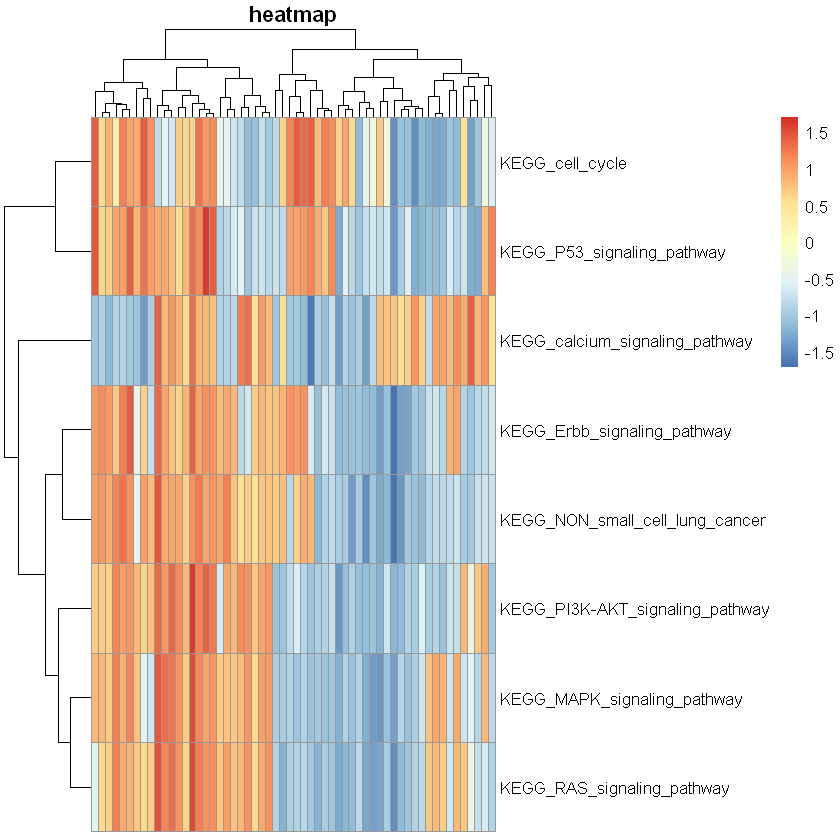

In [9]:
try = pheatmap(GSVA_GSE10245, scale = "row", main = "heatmap", show_colnames=F) 

In [10]:
order_row = try$tree_row$order    # new order of rows
order_col = try$tree_col$order    # new order of columns
datat = data.frame(GSVA_GSE10245[order_row,order_col])   # re-arrange the input data
datat = data.frame(rownames(datat),datat,check.names =F)  
datat = datat[,-1]
datat

,GSM258555,GSM258593,GSM258601,GSM258572,GSM258565,GSM258592,GSM258604,GSM258580,GSM258596,GSM258579,...,GSM258568,GSM258576,GSM258581,GSM258564,GSM258598,GSM258560,GSM258551,GSM258577,GSM258583,GSM258606
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
KEGG_cell_cycle,0.5217607,0.2143067,0.3154156,0.1225604,0.4499875,0.3548327,0.3371044,0.5289957,0.4066727,-0.3313245,...,-0.5044335,-0.5236728,-0.5062844,-0.4252941,-0.4558518,0.1759296,-0.53786988,-0.4163831,-0.1300890,-0.2446182
KEGG_P53_signaling_pathway,0.4316244,0.1765020,0.1838326,0.2865021,0.2917942,0.4224562,0.2550754,0.3743358,0.2946486,0.2683391,...,-0.3762839,-0.3894248,-0.3585600,-0.2244154,-0.2969230,-0.2487055,-0.42303294,-0.4271648,0.2329712,0.3499423
KEGG_calcium_signaling_pathway,-0.2015039,-0.1782639,-0.2312865,-0.1697787,-0.1756856,-0.1901727,-0.2024992,-0.2734912,-0.1797996,0.3034684,...,-0.1514650,0.2138676,0.2143830,0.1825887,0.2455548,0.2103959,0.30994593,0.1879264,0.2388548,0.1232725
KEGG_Erbb_signaling_pathway,0.3099331,0.3365934,0.3024233,0.2183519,0.3562961,0.4173271,-0.1389568,0.1960624,-0.2398683,0.3964646,...,-0.2266368,-0.2174401,-0.2655696,0.2559121,0.2822473,-0.2738988,-0.32056673,-0.2543083,-0.2486219,-0.2102477
KEGG_NON_small_cell_lung_cancer,0.2960430,0.3140449,0.2703831,0.3546042,0.3763413,0.3331334,-0.1511309,0.2976510,0.2373345,0.4307118,...,-0.2756474,-0.2538734,-0.2659448,-0.2479942,-0.2200388,-0.2993906,-0.31197902,-0.2290889,-0.2185274,-0.2304958
KEGG_PI3K-AKT_signaling_pathway,0.1449167,0.1453462,0.1422116,0.2576246,0.2184114,0.2345183,0.1824866,0.1315513,0.1610852,0.2978967,...,-0.2373358,-0.2226253,-0.2622411,-0.1765687,-0.1900583,0.1771871,-0.10689399,0.1539863,0.1926893,-0.2478072
KEGG_MAPK_signaling_pathway,0.1959850,0.1954933,0.1631346,0.2857017,0.2088495,0.2784992,0.1824084,-0.1383906,-0.1813584,0.3516686,...,0.1851264,0.2289516,0.2081223,-0.1766052,0.2193424,-0.1773990,-0.14075608,-0.2161466,0.1943022,-0.2141057
KEGG_RAS_signaling_pathway,-0.1268862,0.1512442,0.1645584,0.3016884,0.2258220,0.2220332,0.1805754,0.1475663,0.1761918,0.3688800,...,0.1822281,0.2049527,0.1774546,-0.1654386,0.2087538,0.1816282,-0.09831903,-0.1854455,-0.1560856,-0.2258124


In [11]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 18363)

Matrix products: default

locale:
[1] LC_COLLATE=Chinese (Simplified)_China.936 
[2] LC_CTYPE=Chinese (Simplified)_China.936   
[3] LC_MONETARY=Chinese (Simplified)_China.936
[4] LC_NUMERIC=C                              
[5] LC_TIME=Chinese (Simplified)_China.936    

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] pheatmap_1.0.12      GSEABase_1.48.0      graph_1.64.0        
 [4] annotate_1.64.0      XML_3.99-0.3         AnnotationDbi_1.48.0
 [7] IRanges_2.20.2       S4Vectors_0.24.4     Biobase_2.46.0      
[10] BiocGenerics_0.32.0  GSVA_1.34.0         

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3       repr_1.1.0         colorspace_1.4-1   vctrs_0.2.4       
 [5] htmltools_0.4.0    base64enc_0.1-3    blob_1.2.1         rlang_0.4.5       
 [9] late